In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import label_binarize


from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [26]:
# Load processed MFCC features and labels
X_train = np.load('../data/processed/X_train_reduced.npy')
X_test = np.load('../data/processed/X_test_reduced.npy')
y_train = np.load('../data/processed/y_train.npy')
y_test = np.load('../data/processed/y_test.npy')

# Check the shapes of loaded data
print("Data Loaded Successfully:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Data Loaded Successfully:
X_train shape: (85087, 17)
X_test shape: (21272, 17)
y_train shape: (85087,)
y_test shape: (21272,)


In [27]:
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)
    elif hasattr(model, "decision_function"):
        y_prob = model.decision_function(X_test)
        if len(np.unique(y_test)) > 2:
            y_prob = label_binarize(y_prob, classes=np.unique(y_test))
    else:
        raise ValueError(f"{name} does not support probability predictions.")

    classes = np.unique(y_test)
    y_test_bin = label_binarize(y_test, classes=classes)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    roc_auc = roc_auc_score(y_test_bin, y_prob, average='macro', multi_class='ovr')

    print(f"\n{name} Performance:")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"ROC AUC  : {roc_auc:.4f}")

    plt.figure(figsize=(8, 6))

    class_names = ['adult', 'middle_aged', 'teen', 'young_adult']

    for i in range(y_test_bin.shape[1]):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        auc_i = roc_auc_score(y_test_bin[:, i], y_prob[:, i])
        label = f"{class_names[i]} (AUC = {auc_i:.2f})" if class_names else f"Class {i}"
        plt.plot(fpr, tpr, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f"{name} - ROC Curves")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names if class_names else classes)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

    plt.figure(figsize=(8, 6))
    for i in range(y_test_bin.shape[1]):
        precision_curve, recall_curve, _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
        ap = average_precision_score(y_test_bin[:, i], y_prob[:, i])
        label = f"{class_names[i]} (AP = {ap:.2f})" if class_names else f"Class {i}"
        plt.plot(recall_curve, precision_curve, label=label)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{name} - Precision-Recall Curves")
    plt.legend()
    plt.grid(True)
    plt.show()

    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        indices = np.argsort(importances)[-20:]
        plt.figure(figsize=(8, 6))
        plt.barh(range(len(indices)), importances[indices])
        plt.yticks(range(len(indices)), [f"Feature {i}" for i in indices])
        plt.title(f"{name} - Top 20 Feature Importances")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()

    return {
        'name': name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'y_pred': y_pred,
        'y_prob': y_prob
    }

In [28]:
results = []

Best Parameters: {'C': 0.1, 'penalty': 'l2'}

Logistic Regression Performance:
Accuracy : 0.5658
Precision: 0.5162
Recall   : 0.3639
F1 Score : 0.3796
ROC AUC  : 0.7548


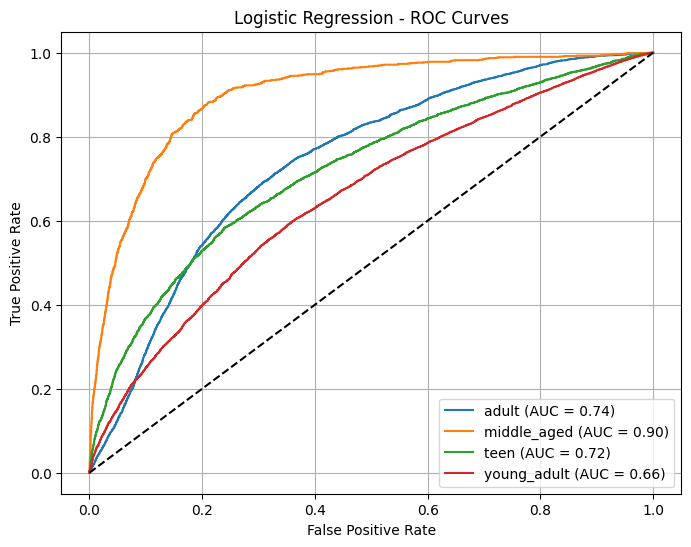

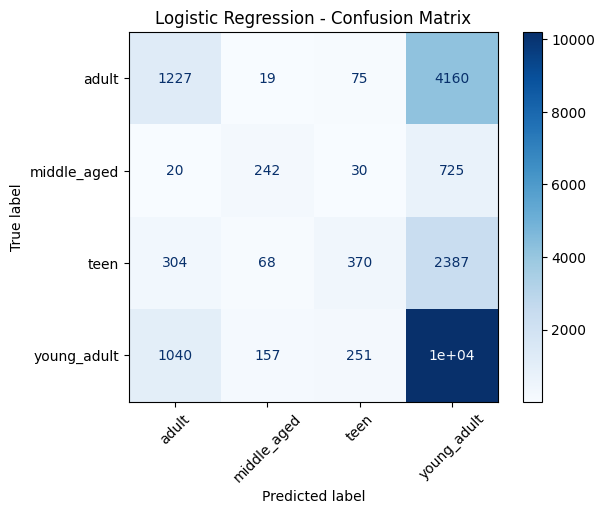

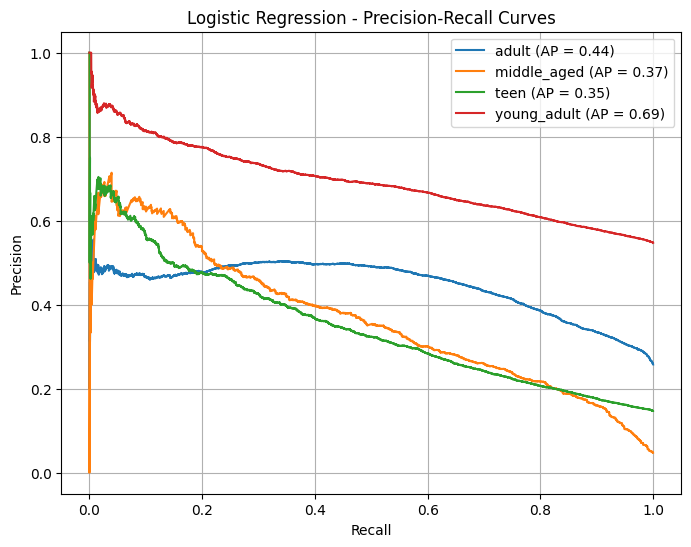

In [29]:
# Logistic Regression

log_params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
}

grid_lr = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42), 
    log_params, 
    cv=5
)
grid_lr.fit(X_train, y_train)

# Getting the best model
best_log = grid_lr.best_estimator_
print("Best Parameters:", grid_lr.best_params_)

# Evaluating
results.append(evaluate_model("Logistic Regression", best_log, X_test, y_test))

Best Parameters: {'C': 10, 'kernel': 'rbf'}

SVM Performance:
Accuracy : 0.6991
Precision: 0.7246
Recall   : 0.5548
F1 Score : 0.6034
ROC AUC  : 0.8559


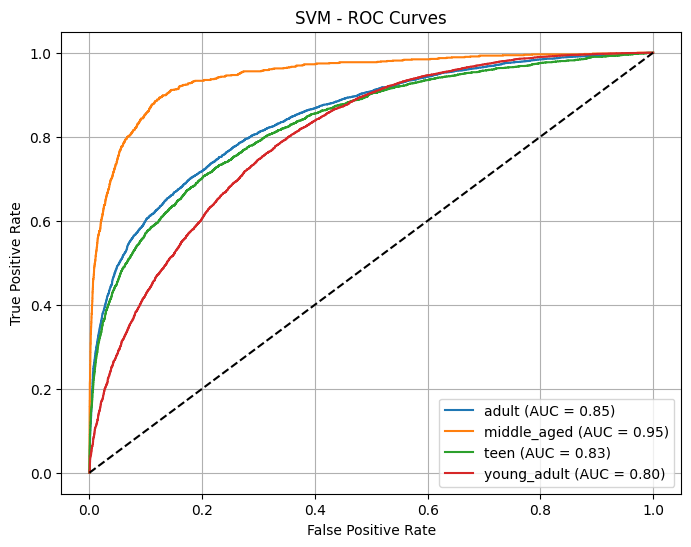

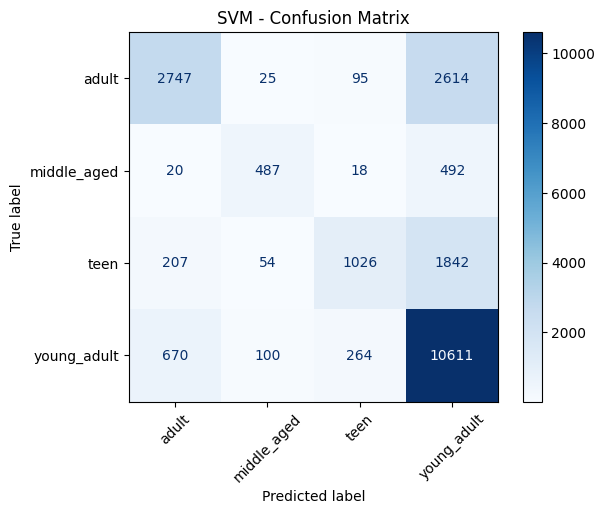

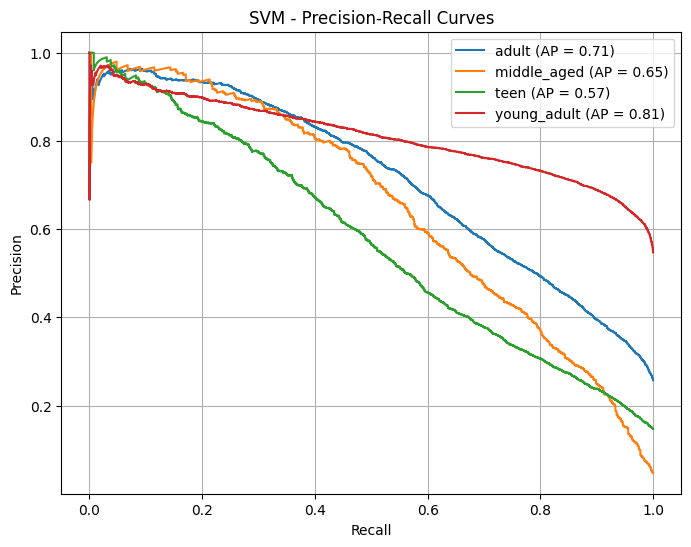

In [30]:
# Support Vector Machine

svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf']
}

grid_svm = GridSearchCV(
    SVC(probability=True, random_state=42),
    svm_params,
    cv=5,
    scoring='f1_macro', 
    n_jobs=-1
)
grid_svm.fit(X_train, y_train)

best_svm = grid_svm.best_estimator_
print("Best Parameters:", grid_svm.best_params_)

results.append(evaluate_model("SVM", best_svm, X_test, y_test))

Best Parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}

Random Forest Performance:
Accuracy : 0.6760
Precision: 0.7638
Recall   : 0.4621
F1 Score : 0.5139
ROC AUC  : 0.8447


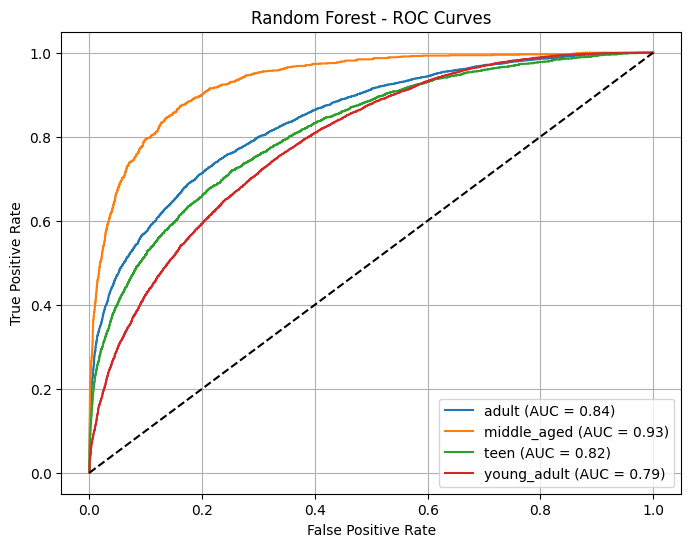

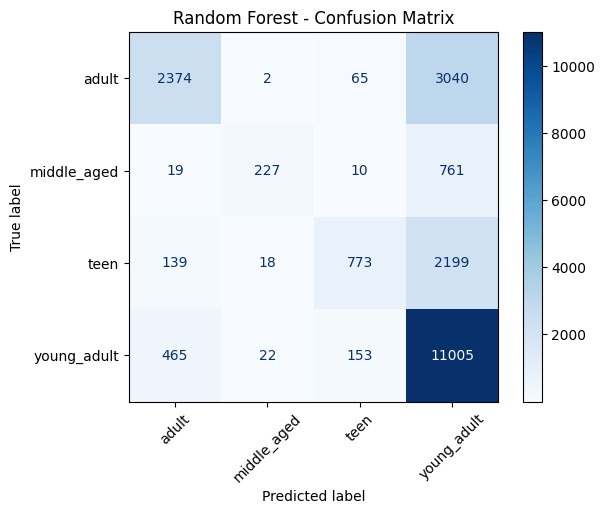

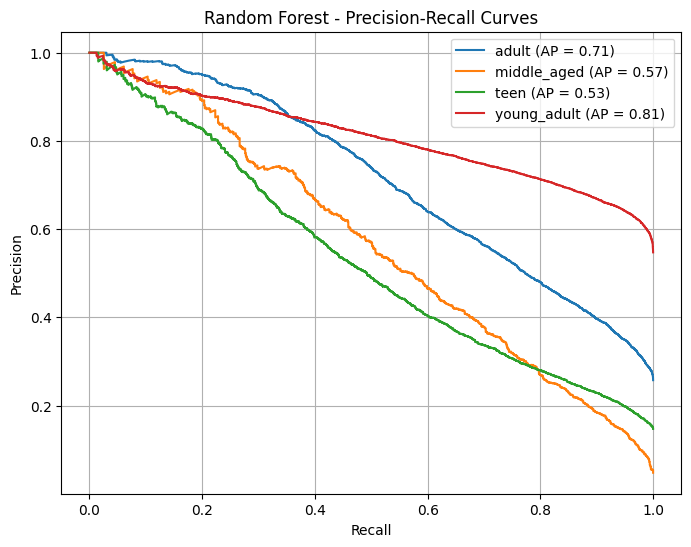

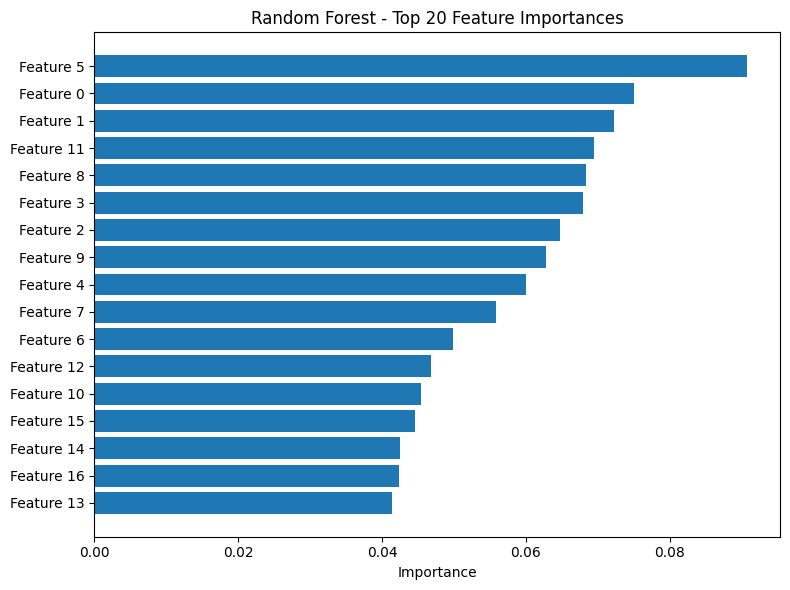

In [31]:
# Random Forest

rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [2]
}

grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_params,
    cv=5,
    scoring='f1_macro', 
    n_jobs=-1
)
grid_rf.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_
print("Best Parameters:", grid_rf.best_params_)

results.append(evaluate_model("Random Forest", best_rf, X_test, y_test))

Best Parameters: {'n_neighbors': 7, 'weights': 'distance'}

KNN Performance:
Accuracy : 0.6726
Precision: 0.6446
Recall   : 0.5135
F1 Score : 0.5513
ROC AUC  : 0.8125


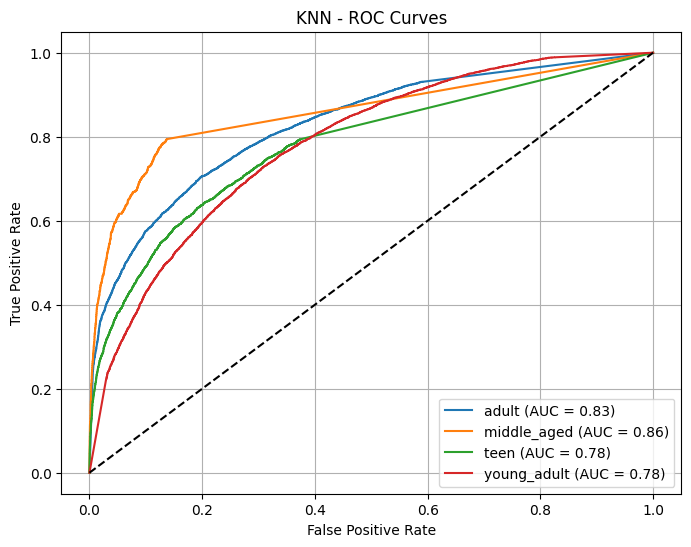

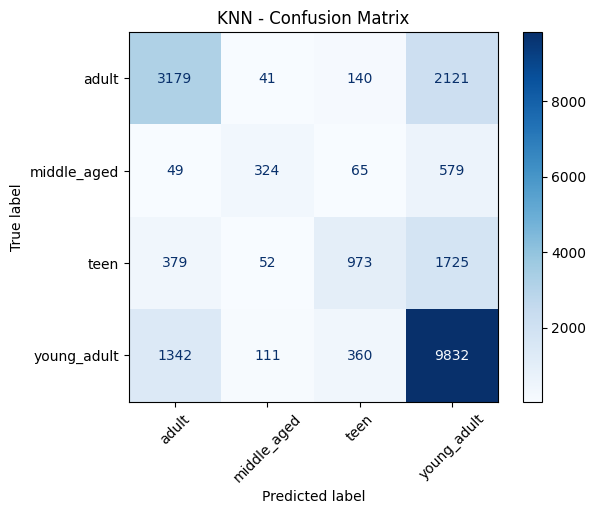

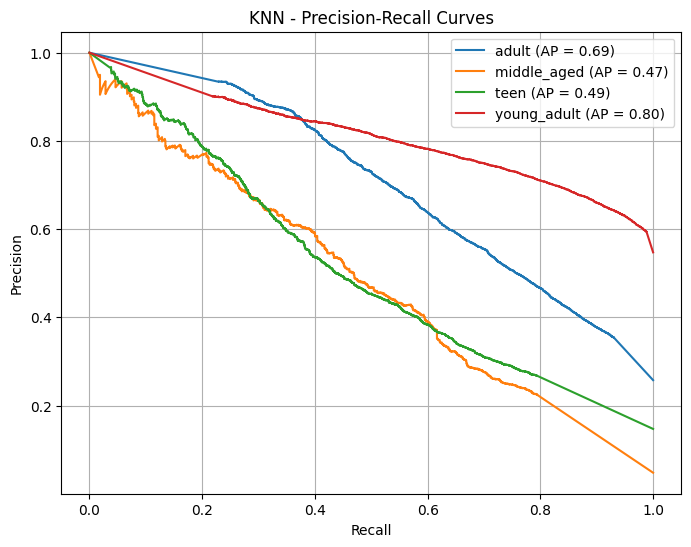

In [32]:
# K-Nearest Neighbors

knn_params = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance']
}

grid_knn = GridSearchCV(
    KNeighborsClassifier(),
    knn_params,
    cv=5
)
grid_knn.fit(X_train, y_train)

best_knn = grid_knn.best_estimator_
print("Best Parameters:", grid_knn.best_params_)

results.append(evaluate_model("KNN", best_knn, X_test, y_test))

Best Parameters: {'bootstrap': True, 'bootstrap_features': True, 'estimator__max_depth': None, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 100}

Bagging Performance:
Accuracy : 0.6598
Precision: 0.7706
Recall   : 0.4234
F1 Score : 0.4637
ROC AUC  : 0.8282


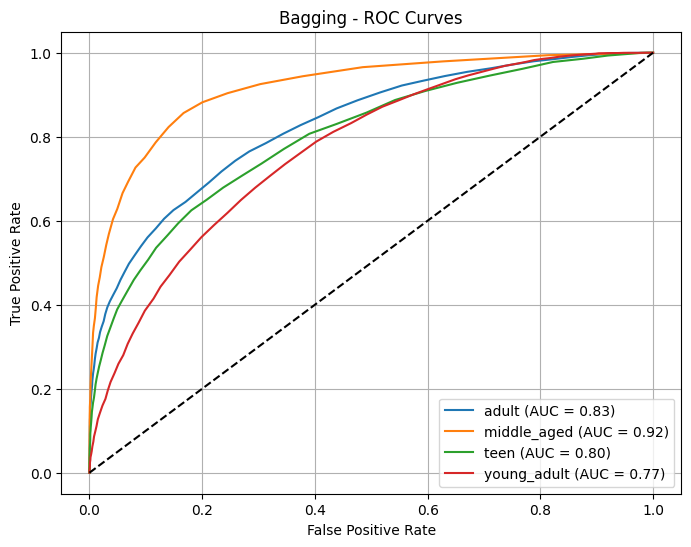

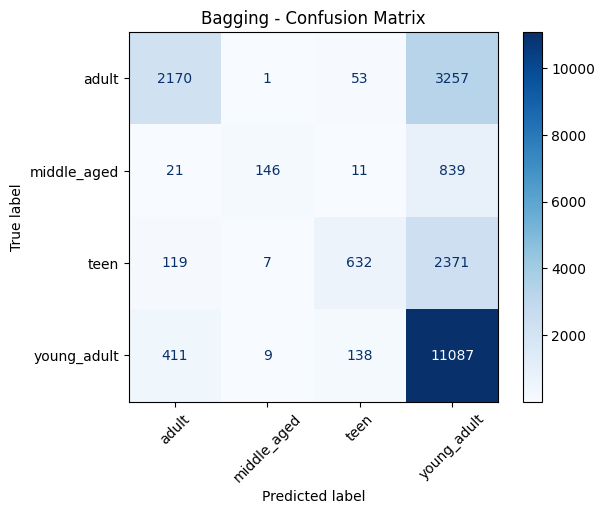

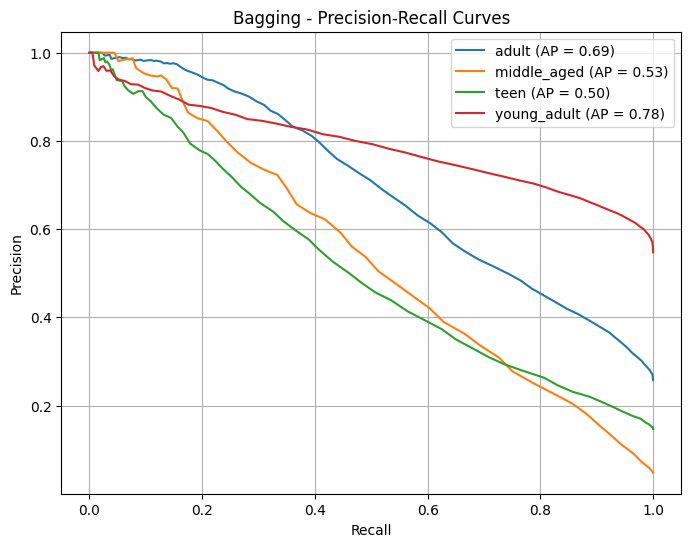

In [33]:
# Bagging Classifier
bag_params = {
    'n_estimators': [10, 50, 100],
    'estimator__max_depth': [None, 5, 10],
    'max_samples': [0.5, 1.0],
    'max_features': [0.5, 1.0],
    'bootstrap': [True],
    'bootstrap_features': [True]
}

grid_bag = GridSearchCV(
    BaggingClassifier(estimator=DecisionTreeClassifier(), random_state=42),
    bag_params,
    cv=5,
    scoring='accuracy'
)
grid_bag.fit(X_train, y_train)

best_bag = grid_bag.best_estimator_
print("Best Parameters:", grid_bag.best_params_)

results.append(evaluate_model("Bagging", best_bag, X_test, y_test))

Best Parameters: {'learning_rate': 1.5, 'n_estimators': 200}

AdaBoost Performance:
Accuracy : 0.5647
Precision: 0.4936
Recall   : 0.3605
F1 Score : 0.3792
ROC AUC  : 0.7250


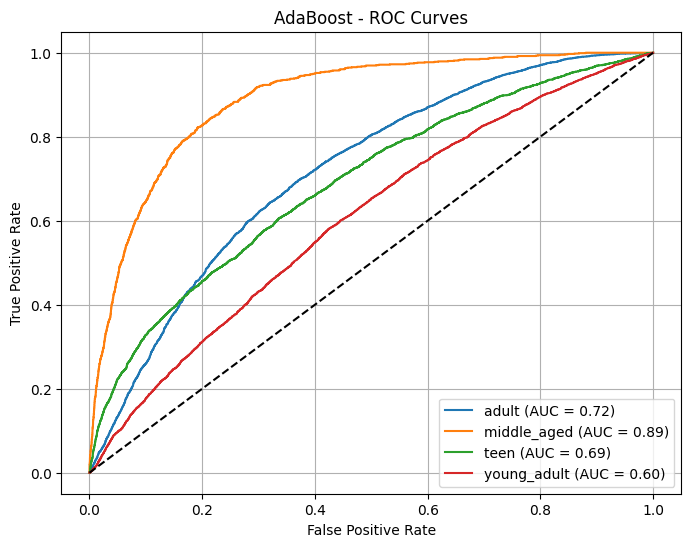

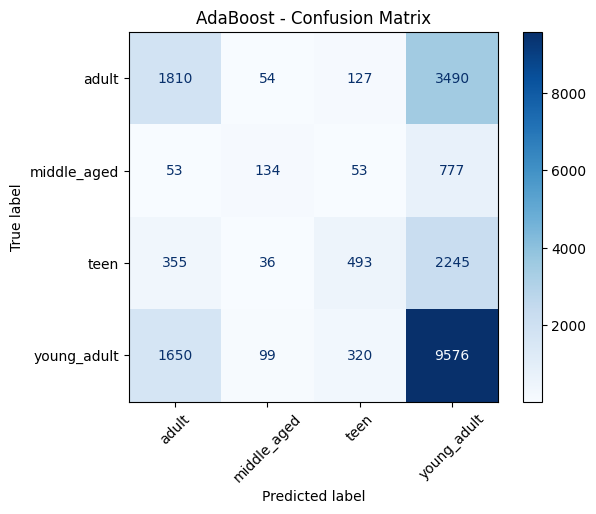

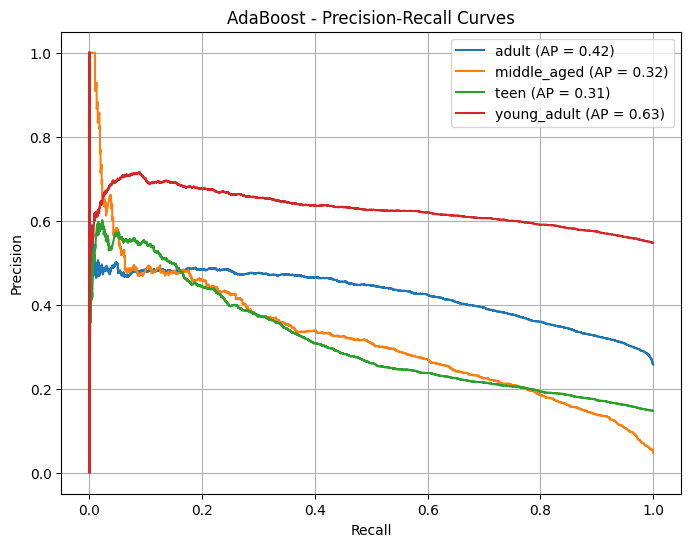

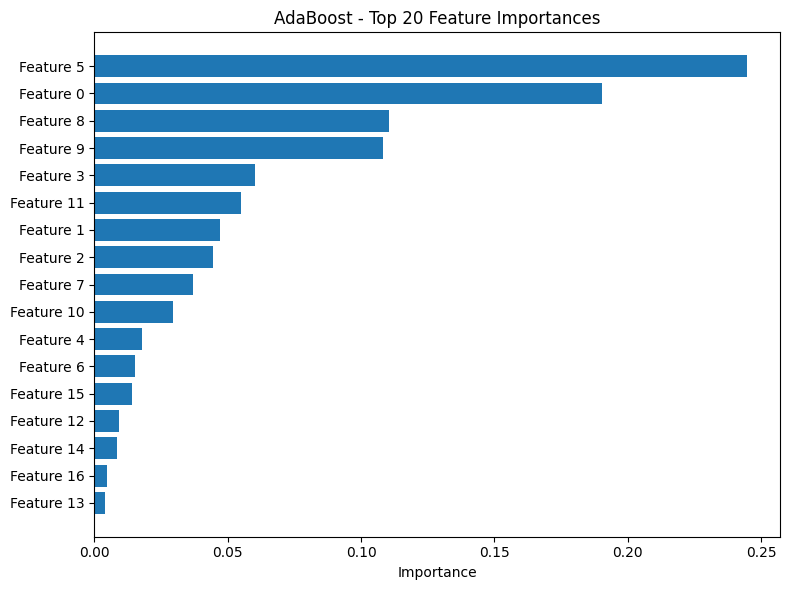

In [34]:
# AdaBoost Classifier

ada_params = {
    'n_estimators': [50, 200],
    'learning_rate': [0.5, 1.0, 1.5]
}

grid_ada = GridSearchCV(
    AdaBoostClassifier(random_state=42),
    ada_params,
    cv=5,
    scoring='accuracy'
)
grid_ada.fit(X_train, y_train)

best_ada = grid_ada.best_estimator_
print("Best Parameters:", grid_ada.best_params_)

results.append(evaluate_model("AdaBoost", best_ada, X_test, y_test))


Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}

XGBoost Performance:
Accuracy : 0.6701
Precision: 0.6860
Recall   : 0.5024
F1 Score : 0.5503
ROC AUC  : 0.8356


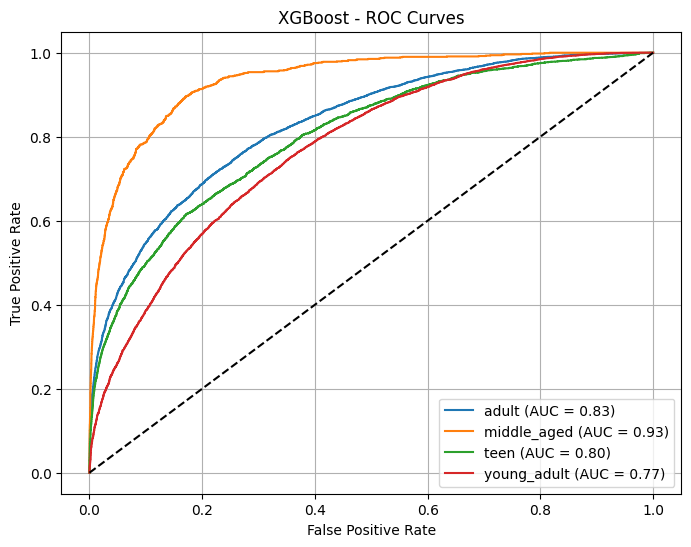

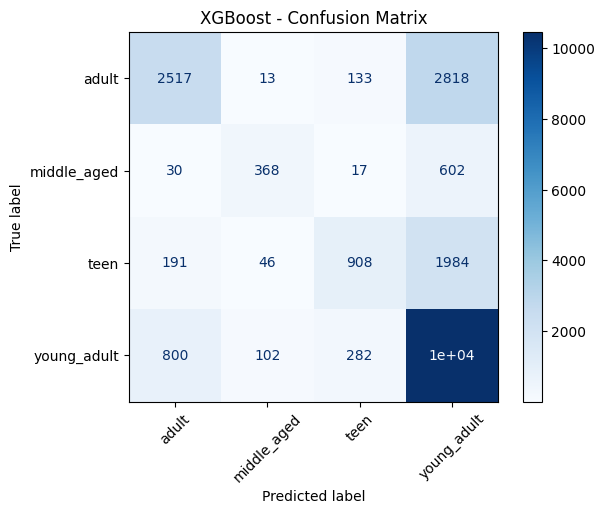

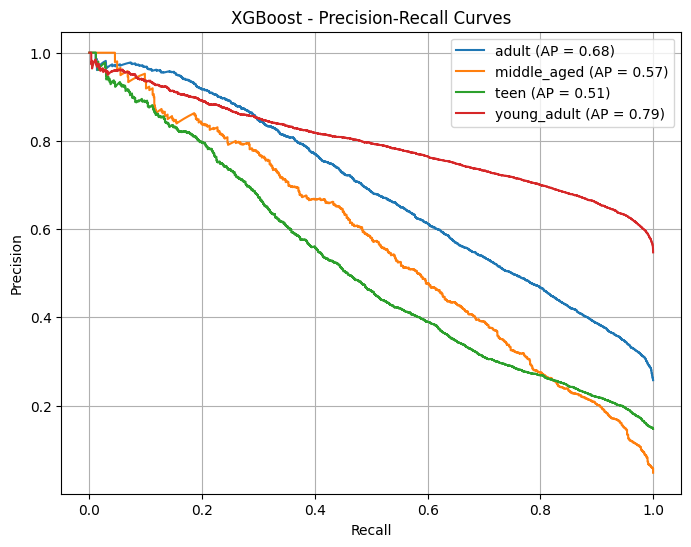

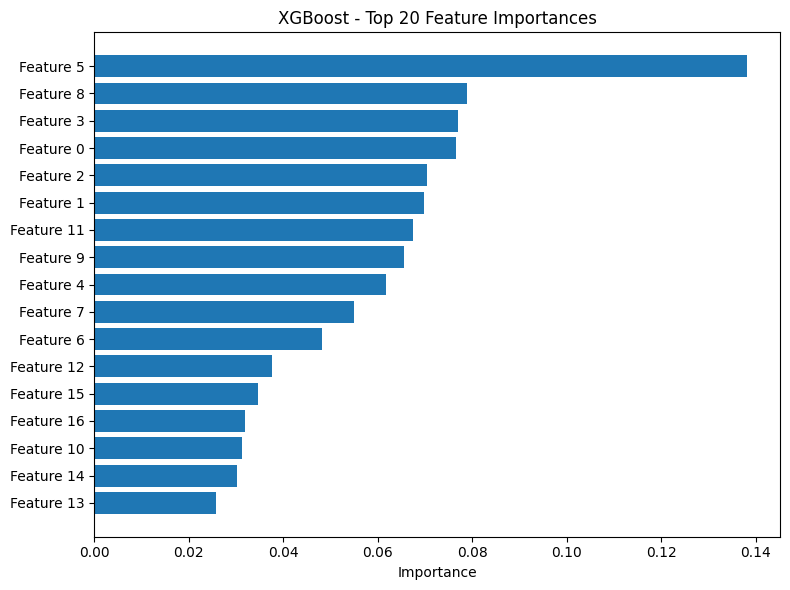

In [35]:
# XGBoost Classifier

xgb_params = {
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5, 7]
}

grid_xgb = GridSearchCV(
    XGBClassifier(eval_metric='logloss', random_state=42),
    xgb_params,
    cv=5,
    scoring='accuracy'
)
grid_xgb.fit(X_train, y_train)

best_xgb = grid_xgb.best_estimator_
print("Best Parameters:", grid_xgb.best_params_)

results.append(evaluate_model("XGBoost", best_xgb, X_test, y_test))

In [ ]:
# Comparison

results_df = pd.DataFrame(results)

# Sort models by F1 score

results_df_sorted = results_df.sort_values(by="f1", ascending=False)
print("Top models based on F1 Score:")
print(results_df_sorted[['name', 'f1', 'accuracy', 'precision', 'recall', 'roc_auc']])


Top models based on F1 Score:
                  name        f1  accuracy  precision    recall   roc_auc
1                  SVM  0.603424  0.699088   0.724587  0.554788  0.855874
3                  KNN  0.551286  0.672621   0.644564  0.513465  0.812531
6              XGBoost  0.550275  0.670083   0.686015  0.502396  0.835635
2        Random Forest  0.513910  0.675959   0.763846  0.462106  0.844743
4              Bagging  0.463739  0.659788   0.770649  0.423384  0.828235
0  Logistic Regression  0.379621  0.565814   0.516217  0.363931  0.754819
5             AdaBoost  0.379249  0.564733   0.493626  0.360469  0.725027


In [42]:
# Best model based on F1 score

best_model_by_f1 = results_df_sorted.iloc[0]
print(f"\nBest model based on F1 Score: {best_model_by_f1['name']} (F1 = {best_model_by_f1['f1']:.4f})")


Best model based on F1 Score: SVM (F1 = 0.6034)


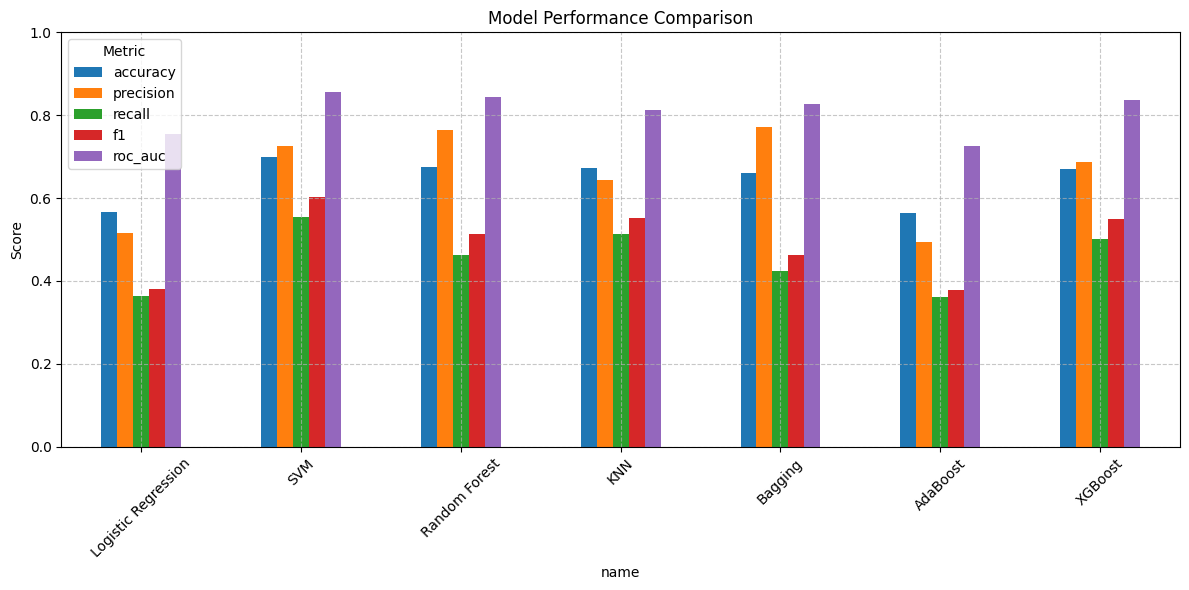

In [ ]:
# Plotting for model performance comparison

results_df_plot = results_df.set_index('name')

metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
results_df_plot[metrics_to_plot].plot(kind='bar', figsize=(12, 6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title="Metric")
plt.tight_layout()
plt.show()


# Voice Age Group Classification – Model Evaluation Summary

## Objective
To classify speakers into age groups using audio features (MFCCs) extracted from the Mozilla Common Voice dataset.


## Models Evaluated

- Logistic Regression  
- Support Vector Machine (SVM)  
- Random Forest  
- K-Nearest Neighbors (KNN)  
- Bagging  
- AdaBoost  
- XGBoost  


This 3rd evaluation part is based on the 2nd part (model_development), and here hyperparameter tuning and evaluation are added.


## Evaluation Metrics

- **Accuracy**: Overall correctness of predictions.  
- **Precision (Macro)**: Proportion of true positives among all positive predictions, averaged across classes.  
- **Recall (Macro)**: Proportion of true positives among all actual positives, averaged across classes.  
- **F1 Score (Macro)**: Harmonic mean of precision and recall, averaged across all classes.  
- **ROC AUC**: Ability to distinguish between classes using predicted probabilities.

---

## Top 3 Models by F1 Score

| Model         | F1 Score | Accuracy | Precision | Recall | ROC AUC |
|---------------|----------|----------|-----------|--------|---------|
| **SVM**       | **0.603**| 0.699    | 0.725     | 0.555  | 0.856   |
| KNN           | 0.551    | 0.673    | 0.645     | 0.513  | 0.813   |
| XGBoost       | 0.550    | 0.670    | 0.686     | 0.502  | 0.836   |



## Key Insights

- **SVM outperformed all other models** in F1 Score, Accuracy, and ROC AUC, making it the most balanced classifier.
- Tree-based models like Random Forest and XGBoost had **high precision but lower recall**, suggesting they favored dominant classes.
- Simpler models like Logistic Regression and AdaBoost underperformed, likely due to the nonlinear nature of audio features.



## Conclusion
The **SVM model is the best-performing model** for multiclass age group classification based on voice data, achieving:
- **F1 Score**: 0.60  
- **Accuracy**: ~70%  
- **Precision**: 0.725  
- **Recall**: 0.555  
- **ROC AUC**: 0.86  

These results are a **strong baseline**, considering the limited feature set and traditional ML approach.